# Učitavanje podataka

In [13]:
import joblib
import numpy as np
# ucitavanje prethodno podeljenih skupova podataka

#ucitavanje skupova podataka bez redukcije dimenzionalnosti
X_org_train, X_org_val, y_org_train, y_org_validation = joblib.load("unsw_trv_unprocessed.pkl")
X_org_test, y_org_test = joblib.load("unsw_test_unprocessed.pkl")
X_org_combined = np.concatenate([X_org_train, X_org_val], axis=0)
y_org_combined = np.concatenate([y_org_train, y_org_validation], axis=0)
print("Original Training set:" + str(X_org_combined.shape) + "\nOriginal Test set:" + str(X_org_test.shape))


# ucitavanje korelaciono obradjenih skupova podataka
X_test, y_test = joblib.load("unsw_corr_test.pkl")
X_train, y_train = joblib.load("unsw_corr_train.pkl")
X_validation, y_validation = joblib.load("unsw_corr_val.pkl")
X_combined = np.concatenate([X_train, X_validation], axis=0)
y_combined = np.concatenate([y_train, y_validation], axis=0)
print("Training set:" + str(X_combined.shape) + "\nTest set:" + str(X_test.shape))

#ucitavanje PCA transformisanih skupova podataka
_,_,y_train_pca,y_validation_pca = joblib.load("unsw_trv_unprocessed.pkl")
X_train_pca, X_validation_pca, X_test_pca = joblib.load("unsw_pca.pkl")
X_pca_combined = np.concatenate([X_train_pca, X_validation_pca], axis=0)
y_pca_combined = np.concatenate([y_train_pca, y_validation_pca], axis=0)
print("PCA Training set:" + str(X_pca_combined.shape) + "\nPCA Test set:" + str(X_test_pca.shape))

# ucitavanje autoenkoderski transformisanih skupova podataka
X_train_autoenc, y_train_autoenc = joblib.load("new_unsw_train_reduced_autoenc.pkl")
X_test_autoenc, y_test_eutoenc = joblib.load("new_unsw_test_reduced_autoenc.pkl")
print("Autoencoder Training set:" + str(X_train_autoenc.shape) + "\nAutoencoder Test set:" + str(X_test_autoenc.shape))

Original Training set:(175318, 41)
Original Test set:(82328, 41)
Training set:(198019, 18)
Test set:(82328, 18)
PCA Training set:(175318, 16)
PCA Test set:(82328, 16)
Autoencoder Training set:(175318, 20)
Autoencoder Test set:(82328, 20)


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import time

def train_xgboost_classifier(X_train, X_test, y_train, y_test):

    #labelEncoder za target promenljivu(attack_cat)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        eval_metric='mlogloss'
    )

    print("Pocinje treniranje XGBoost modela...")
    start_time = time.time()
    xgb_model.fit(X_train, y_train_encoded)
    training_time = time.time() - start_time
    print(f"Treniranje zavrseno za {training_time:.2f} sekundi")

    print("Pravi predvidjanja...")
    y_pred_encoded = xgb_model.predict(X_test)
    y_pred = le.inverse_transform(y_pred_encoded)

    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"\nTacnost modela: {accuracy:.4f} ({accuracy*100:.2f}%)")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    return {
        'model': xgb_model,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'train_time': training_time,
        'predictions': y_pred
    }


In [16]:
def xgboost_grid_search(X_train, X_test, y_train, y_test, param_grid=None, cv=3, scoring='macro_f1'):
    if param_grid is None:
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [6, 8],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
        
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    
    scoring_dict = {'macro_f1': make_scorer(f1_score, average='macro')}
    
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    model = xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss',
        tree_method='hist'
    )
    
    grid = GridSearchCV(
        model,
        param_grid,
        scoring=scoring_dict,
        refit='macro_f1',
        cv=cv_strategy,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    
    start = time.time()
    grid.fit(X_train, y_train_enc)
    print(f"Grid Search završio za {(time.time()-start):.2f} sekundi")
    
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_pred_decoded = le.inverse_transform(y_pred)
    
    print("Test set metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_decoded))
    print("Macro F1:", f1_score(y_test, y_pred_decoded, average='macro'))
    print(classification_report(y_test, y_pred_decoded))
    print("Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, y_pred_decoded), 
                                              index=le.classes_, columns=le.classes_))
    
    return {
        'best_model': best_model,
        'best_params': grid.best_params_,
        'cv_best_score': grid.best_score_,
        'label_encoder': le,
        'all_results': pd.DataFrame(grid.cv_results_)
    }

# Treniranje i evaluacija pomoću XGBoost-a

Izabrani model je jedan od najčešće primenjivanih u naučnim radovima i pokazao je jedan od najboljih rezultata. U radovima se uglavnom koriste klasični ML klasifikatori, dok pojedini radovi primenjuju deep learning ili kombinovane metode za feature selection.

 Model ćemo trenirati na tri različita dataseta:
   * na podacima nad kojima je izvršen feature selection pomoću Decision Tree-a i analize korelacije
   * na podacima redukovanim pomoću PCA metode radi zadržavanja najveće varijanse
   * na podacima na kojima je primenjena metoda redukcije pomocu autoenkodera


In [17]:
# cuvamo rezultate u dict kako bismo ih kasnije mogli analizirati
results = {}

In [20]:
results['Original (41D)']=train_xgboost_classifier(X_org_combined, X_org_test, y_org_combined, y_org_test)

Pocinje treniranje XGBoost modela...
Treniranje zavrseno za 14.89 sekundi
Pravi predvidjanja...

Tacnost modela: 0.7653 (76.53%)

Classification report:
                precision    recall  f1-score   support

      Analysis       0.09      0.15      0.11       677
      Backdoor       0.02      0.06      0.03       583
           DoS       0.48      0.07      0.13      4089
      Exploits       0.59      0.87      0.70     11128
       Fuzzers       0.31      0.59      0.41      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.96      0.76      0.85     37000
Reconnaissance       0.92      0.80      0.86      3496
     Shellcode       0.35      0.68      0.46       378
         Worms       0.63      0.27      0.38        44

      accuracy                           0.77     82328
     macro avg       0.54      0.52      0.49     82328
  weighted avg       0.83      0.77      0.78     82328


Confusion Matrix:
[[  101    38    33   446     4     0    

In [21]:
results['DT/Corr feature selection (18D)']=train_xgboost_classifier(X_combined, X_test, y_combined, y_test)

Pocinje treniranje XGBoost modela...
Treniranje zavrseno za 11.79 sekundi
Pravi predvidjanja...

Tacnost modela: 0.7551 (75.51%)

Classification report:
                precision    recall  f1-score   support

      Analysis       0.06      0.27      0.09       677
      Backdoor       0.62      0.05      0.10       583
           DoS       0.47      0.12      0.19      4089
      Exploits       0.59      0.87      0.70     11128
       Fuzzers       0.32      0.57      0.41      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.96      0.73      0.83     37000
Reconnaissance       0.93      0.79      0.85      3496
     Shellcode       0.18      0.87      0.30       378
         Worms       0.41      0.70      0.52        44

      accuracy                           0.76     82328
     macro avg       0.56      0.59      0.50     82328
  weighted avg       0.84      0.76      0.77     82328


Confusion Matrix:
[[  184     0    15   419     2     0    

In [22]:
results['PCA (16D)'] = train_xgboost_classifier(X_pca_combined, X_test_pca, y_pca_combined, y_test)

Pocinje treniranje XGBoost modela...
Treniranje zavrseno za 11.48 sekundi
Pravi predvidjanja...

Tacnost modela: 0.7334 (73.34%)

Classification report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.01      0.03      0.02       583
           DoS       0.32      0.05      0.08      4089
      Exploits       0.56      0.86      0.68     11128
       Fuzzers       0.27      0.58      0.37      6062
       Generic       1.00      0.94      0.97     18871
        Normal       0.94      0.72      0.81     37000
Reconnaissance       0.67      0.76      0.71      3496
     Shellcode       0.39      0.48      0.43       378
         Worms       1.00      0.07      0.13        44

      accuracy                           0.73     82328
     macro avg       0.52      0.45      0.42     82328
  weighted avg       0.79      0.73      0.74     82328


Confusion Matrix:
[[    0    16    59   535    18     0    

In [23]:
results['Autoenkoder (20D)'] = train_xgboost_classifier(X_train_autoenc, X_test_autoenc, y_train_autoenc, y_test_eutoenc)

Pocinje treniranje XGBoost modela...
Treniranje zavrseno za 12.33 sekundi
Pravi predvidjanja...

Tacnost modela: 0.7311 (73.11%)

Classification report:
                precision    recall  f1-score   support

      Analysis       0.01      0.01      0.01       677
      Backdoor       0.06      0.05      0.05       583
           DoS       0.49      0.03      0.06      4089
      Exploits       0.54      0.90      0.68     11128
       Fuzzers       0.27      0.58      0.37      6062
       Generic       1.00      0.90      0.94     18871
        Normal       0.96      0.72      0.82     37000
Reconnaissance       0.67      0.78      0.72      3496
     Shellcode       0.39      0.45      0.42       378
         Worms       0.60      0.14      0.22        44

      accuracy                           0.73     82328
     macro avg       0.50      0.46      0.43     82328
  weighted avg       0.81      0.73      0.74     82328


Confusion Matrix:
[[    6    21    12   583     3     0    


 Poredjenje performansi razlicitih modela:

                                 Accuracy  F1 Macro  F1 Weighted  \
DT/Corr feature selection (18D)    0.7551    0.4980       0.7733   
Original (41D)                     0.7653    0.4911       0.7770   
Autoenkoder (20D)                  0.7311    0.4286       0.7396   
PCA (16D)                          0.7334    0.4197       0.7433   

                                 Train Time (s)  
DT/Corr feature selection (18D)         11.7942  
Original (41D)                          14.8917  
Autoenkoder (20D)                       12.3348  
PCA (16D)                               11.4801  


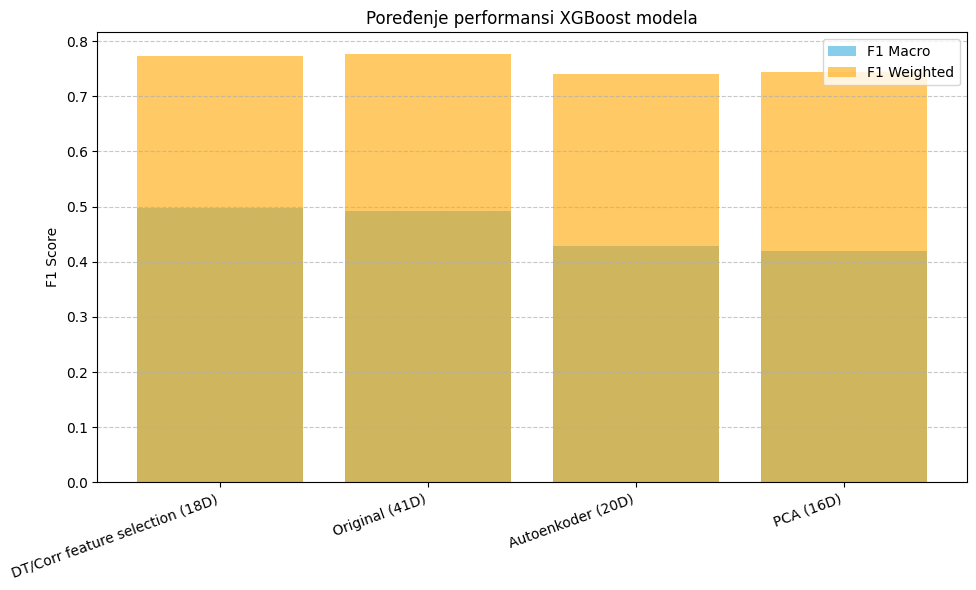

In [ ]:
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame({
    model_name: {
        'Accuracy': res['accuracy'],
        'F1 Macro': res['f1_macro'],
        'F1 Weighted': res['f1_weighted'],
        'Train Time (s)': res['train_time']
    }
    for model_name, res in results.items()
}).T

comparison_df = comparison_df.sort_values(by='F1 Macro', ascending=False)

print("\n Poredjenje performansi razlicitih modela:\n")
print(comparison_df.round(4))

plt.figure(figsize=(10,6))
plt.bar(comparison_df.index, comparison_df['F1 Macro'], color='skyblue', label='F1 Macro')
plt.bar(comparison_df.index, comparison_df['F1 Weighted'], color='orange', alpha=0.6, label='F1 Weighted')
plt.ylabel('F1 Score')
plt.title('Poređenje performansi XGBoost modela')
plt.xticks(rotation=20, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#pokrecemo grid search za DT/Corr skup podataka - koji se pokazao najboljim
results_best = xgboost_grid_search(
    X_combined, X_test, y_combined, y_test, scoring='macro_f1'
)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Grid Search završio za 2092.07 sekundi
Test set metrics:
Accuracy: 0.7514211446895346
Macro F1: 0.5158149862457757
                precision    recall  f1-score   support

      Analysis       0.06      0.29      0.10       677
      Backdoor       0.09      0.15      0.11       583
           DoS       0.46      0.18      0.25      4089
      Exploits       0.63      0.81      0.71     11128
       Fuzzers       0.28      0.51      0.36      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.96      0.74      0.83     37000
Reconnaissance       0.92      0.80      0.85      3496
     Shellcode       0.25      0.83      0.38       378
         Worms       0.54      0.59      0.57        44

      accuracy                           0.75     82328
     macro avg       0.52      0.59      0.52     82328
  weighted avg       0.83      0.75      0.77     82328

Confusion Matrix:
                 An